Attempting to load: dataset.xlsx...
>> Success: Loaded as Excel.
Data Processed. N = 304 participants.

       STATISTICAL SUMMARY

--- Descriptive Statistics ---
                 Variable   Mean  Std Dev  Cronbach Alpha
     Sleep Quality (GSQS)  7.062    2.521           0.505
Emotion Regulation (DERS) 47.803   12.977           0.915

--- Linear Regression Table ---
    Predictor  Beta (Coef)  Std Error  T-Stat  P-Value
    Intercept      34.6820     2.0711 16.7460      0.0
Sleep Quality       1.8578     0.2762  6.7255      0.0

Model R-Squared: 0.1303

       GENERATING PLOTS


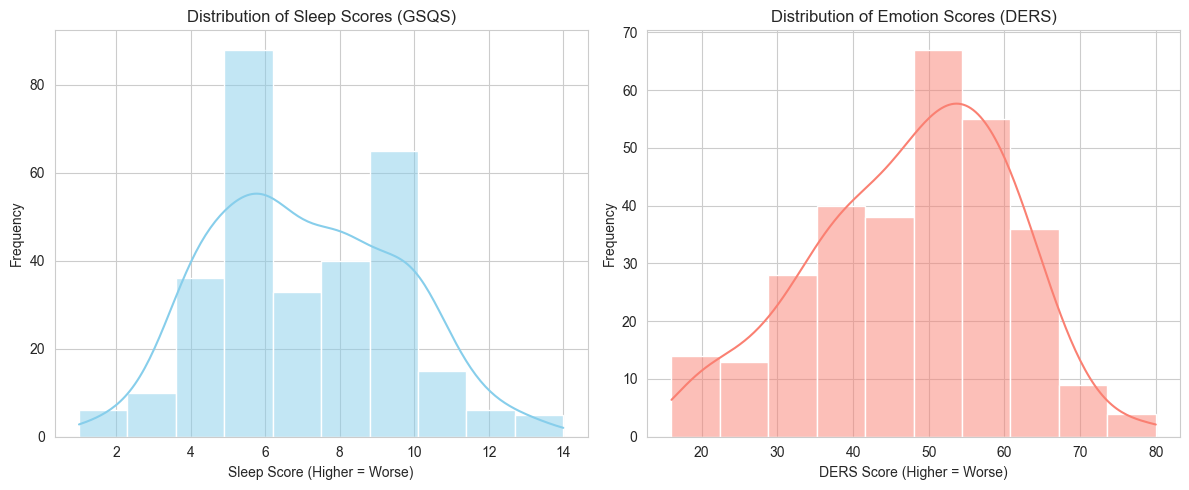

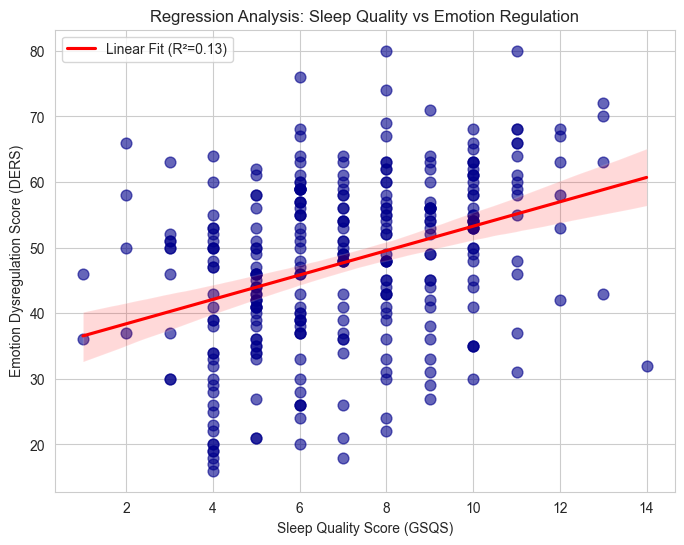

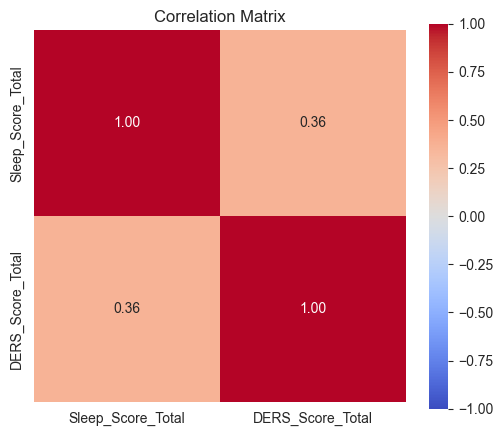

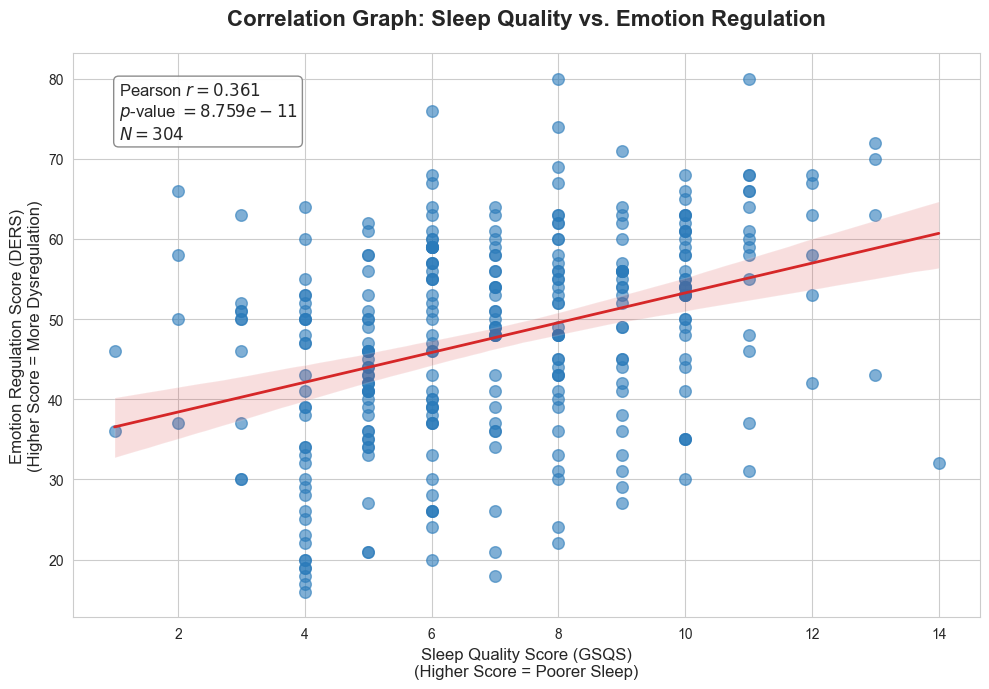


     RAW CORRELATION RESULTS

[ Correlation Matrix Table ]
                   Sleep_Score_Total  DERS_Score_Total
Sleep_Score_Total           1.000000          0.360923
DERS_Score_Total            0.360923          1.000000

[ Detailed Statistics ]
Pearson Coefficient (r): 0.3609234223923897
Sig. (2-tailed) p-value: 8.759313617695048e-11
Sample Size (N):         304
Interpretation:          Significant (p < .05)



In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# Set visual style
sns.set_style("whitegrid")

# ==========================================
# 1. ROBUST DATA LOADING
# ==========================================

# Replace this with your actual file name
# Note: If your file is 'dataset.xlsx', make sure it's actually an Excel file.
# If it's a CSV named .xlsx, the script below will handle it.
file_path = 'dataset.xlsx' 

print(f"Attempting to load: {file_path}...")

try:
    # Try reading as CSV first (Common for Google Forms downloads)
    df = pd.read_csv(file_path)
    print(">> Success: Loaded as CSV.")
except:
    try:
        # If CSV fails, try reading as Excel
        df = pd.read_excel(file_path, engine='openpyxl')
        print(">> Success: Loaded as Excel.")
    except Exception as e:
        print(f"Error: Could not load file. Please check the format.\nDetail: {e}")
        raise

# ==========================================
# 2. DATA CLEANING & SCORING
# ==========================================

# Define Columns by Index
# Cols 2-16 (indices 2 to 17) -> GSQS
# Cols 17-32 (indices 17 to 33) -> DERS
gsqs_cols = df.iloc[:, 2:17].columns.tolist()  
ders_cols = df.iloc[:, 17:33].columns.tolist() 

# Cleaning Map
replace_map = {
    True: 1, False: 0, 
    'True': 1, 'False': 0, 
    'TRUE': 1, 'FALSE': 0,
    'I agree': np.nan 
}

df[gsqs_cols] = df[gsqs_cols].replace(replace_map)

# Coerce to numeric
for col in gsqs_cols + ders_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop missing
df_clean = df.dropna(subset=gsqs_cols + ders_cols).copy()

# Calculate Scores
df_clean['Sleep_Score_Total'] = df_clean[gsqs_cols].sum(axis=1)
df_clean['DERS_Score_Total'] = df_clean[ders_cols].sum(axis=1)

print(f"Data Processed. N = {len(df_clean)} participants.")

# ==========================================
# 3. STATISTICS (Alpha, Correlation, Regression)
# ==========================================

# Cronbach's Alpha Function
def calculate_cronbach_alpha(df_items):
    item_count = df_items.shape[1]
    item_variances = df_items.var(axis=0, ddof=1).sum()
    total_variance = df_items.sum(axis=1).var(ddof=1)
    if total_variance == 0: return 0.0
    return (item_count / (item_count - 1)) * (1 - (item_variances / total_variance))

# Calculate Stats
alpha_sleep = calculate_cronbach_alpha(df_clean[gsqs_cols])
alpha_ders = calculate_cronbach_alpha(df_clean[ders_cols])
r_value, p_value_corr = pearsonr(df_clean['Sleep_Score_Total'], df_clean['DERS_Score_Total'])

# Regression Model
X = sm.add_constant(df_clean['Sleep_Score_Total'])
Y = df_clean['DERS_Score_Total']
model = sm.OLS(Y, X).fit()

# Print Tables
print("\n" + "="*40)
print("       STATISTICAL SUMMARY")
print("="*40)

stats_table = pd.DataFrame({
    'Variable': ['Sleep Quality (GSQS)', 'Emotion Regulation (DERS)'],
    'Mean': [df_clean['Sleep_Score_Total'].mean(), df_clean['DERS_Score_Total'].mean()],
    'Std Dev': [df_clean['Sleep_Score_Total'].std(), df_clean['DERS_Score_Total'].std()],
    'Cronbach Alpha': [alpha_sleep, alpha_ders]
})
print("\n--- Descriptive Statistics ---")
print(stats_table.round(3).to_string(index=False))

print("\n--- Linear Regression Table ---")
reg_summary = pd.DataFrame({
    'Predictor': ['Intercept', 'Sleep Quality'],
    'Beta (Coef)': model.params.values,
    'Std Error': model.bse.values,
    'T-Stat': model.tvalues.values,
    'P-Value': model.pvalues.values
})
print(reg_summary.round(4).to_string(index=False))
print(f"\nModel R-Squared: {model.rsquared:.4f}")

# ==========================================
# 4. DESCRIPTIVE VISUALIZATIONS
# ==========================================

print("\n" + "="*40)
print("       GENERATING PLOTS")
print("="*40)

# Figure 1: Distribution of Scores (Histograms)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['Sleep_Score_Total'], kde=True, color='skyblue', bins=10)
plt.title('Distribution of Sleep Scores (GSQS)')
plt.xlabel('Sleep Score (Higher = Worse)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df_clean['DERS_Score_Total'], kde=True, color='salmon', bins=10)
plt.title('Distribution of Emotion Scores (DERS)')
plt.xlabel('DERS Score (Higher = Worse)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Figure 2: Regression Scatter Plot
plt.figure(figsize=(8, 6))
# regplot draws the scatter points AND the linear regression line with 95% confidence interval
sns.regplot(
    x='Sleep_Score_Total', 
    y='DERS_Score_Total', 
    data=df_clean, 
    color='darkblue',
    scatter_kws={'alpha':0.6, 's':60}, # s is size of dots
    line_kws={'color':'red', 'label': f'Linear Fit (R²={model.rsquared:.2f})'}
)
plt.title('Regression Analysis: Sleep Quality vs Emotion Regulation')
plt.xlabel('Sleep Quality Score (GSQS)')
plt.ylabel('Emotion Dysregulation Score (DERS)')
plt.legend()
plt.show()

# Figure 3: Correlation Heatmap
plt.figure(figsize=(6, 5))
corr_matrix = df_clean[['Sleep_Score_Total', 'DERS_Score_Total']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', square=True)
plt.title('Correlation Matrix')
plt.show()



# ==========================================
# 7. CORRELATION GRAPH (SCATTER PLOT WITH STATS)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Set the figure size
plt.figure(figsize=(10, 7))

# 1. Create the Scatter Plot with Regression Line
# 'regplot' adds the line of best fit and the confidence interval automatically
sns.regplot(
    x='Sleep_Score_Total', 
    y='DERS_Score_Total', 
    data=df_clean, 
    color='#2b7bba',       # Professional blue color
    marker='o',            # Circle dots
    scatter_kws={'s': 70, 'alpha': 0.6}, # Size and transparency of dots
    line_kws={'color': '#d62728', 'linewidth': 2} # Red regression line
)

# 2. Calculate Statistics for the Annotation
r, p = pearsonr(df_clean['Sleep_Score_Total'], df_clean['DERS_Score_Total'])

# 3. Add the Annotation Box to the Plot
# This places a small box with the R and P values inside the graph
text_str = f'Pearson $r = {r:.3f}$\n$p$-value $ = {p:.3e}$\n$N = {len(df_clean)}$'

plt.gca().text(
    0.05, 0.95, text_str, 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top', 
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='gray')
)

# 4. Labels and Title
plt.title('Correlation Graph: Sleep Quality vs. Emotion Regulation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Sleep Quality Score (GSQS)\n(Higher Score = Poorer Sleep)', fontsize=12)
plt.ylabel('Emotion Regulation Score (DERS)\n(Higher Score = More Dysregulation)', fontsize=12)

# 5. Save and Show
plt.tight_layout()
plt.savefig('Correlation_Graph_Annotated.png', dpi=300) # Saves a high-res image
plt.show()

# ==========================================
# 8. PRINT RAW CORRELATION RESULTS
# ==========================================
from scipy.stats import pearsonr

print("\n" + "="*40)
print("     RAW CORRELATION RESULTS")
print("="*40)

# 1. Print the Correlation Matrix (The Table)
corr_matrix = df_clean[['Sleep_Score_Total', 'DERS_Score_Total']].corr()
print("\n[ Correlation Matrix Table ]")
print(corr_matrix)

# 2. Print the Detailed Pearson Stats
r_val, p_val = pearsonr(df_clean['Sleep_Score_Total'], df_clean['DERS_Score_Total'])

print("\n[ Detailed Statistics ]")
print(f"Pearson Coefficient (r): {r_val}")
print(f"Sig. (2-tailed) p-value: {p_val}")
print(f"Sample Size (N):         {len(df_clean)}")

# Interpretation logic
if p_val < 0.05:
    sig_text = "Significant (p < .05)"
else:
    sig_text = "Not Significant (p > .05)"

print(f"Interpretation:          {sig_text}")
print("="*40 + "\n")